In [ ]:
# downloaded data from Kaggle and loaded into Google Colab

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving archive.zip to archive.zip
User uploaded file "archive.zip" with length 126358582 bytes


In [ ]:
# extracting the dataset

from zipfile import ZipFile
folder = "archive.zip"
with ZipFile(folder, 'r') as zip:
  zip.extractall()
  print("Folder data available!")

Folder data available!


Checking training data

In [ ]:
import os
path = "images/images/train/"
for folder in os.listdir(path):
  print(str(len(os.listdir(path + folder))) + " images in folder: " + folder)

4938 images in folder: sad
3205 images in folder: surprise
436 images in folder: disgust
7164 images in folder: happy
4982 images in folder: neutral
4103 images in folder: fear
3993 images in folder: angry


In [ ]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout
from tensorflow.keras.layers import Flatten, Dense, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical
!pip install livelossplot
from tqdm.notebook import tqdm
from IPython.display import SVG, Image
import matplotlib.pyplot as plt
from livelossplot.tf_keras import PlotLossesCallback


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
trainPath = "images/images/train/"
validationPath = "images/images/validation/"

In [ ]:
def getImagesAndLabels(path):
    imagePath = []
    labelPath = []
    
    for value in os.listdir(path):
        for filename in os.listdir(path+value):
            imagepath = os.path.join(path,value,filename)
            imagePath.append(imagepath)
            labelPath.append(value)
        
    return imagePath, labelPath

In [ ]:
train = pd.DataFrame()
train['image'], train['label'] = getImagesAndLabels(trainPath)
train = train.sample(frac=1).reset_index(drop=True)
train.head()

,image,label
0,images/images/train/fear/4531.jpg,fear
1,images/images/train/angry/12235.jpg,angry
2,images/images/train/sad/31600.jpg,sad
3,images/images/train/sad/4528.jpg,sad
4,images/images/train/neutral/35606.jpg,neutral


In [ ]:
validation = pd.DataFrame()
validation['image'], validation['label'] = getImagesAndLabels(validationPath)
validation.head()

,image,label
0,images/images/validation/sad/34121.jpg,sad
1,images/images/validation/sad/31009.jpg,sad
2,images/images/validation/sad/33691.jpg,sad
3,images/images/validation/sad/32859.jpg,sad
4,images/images/validation/sad/34633.jpg,sad


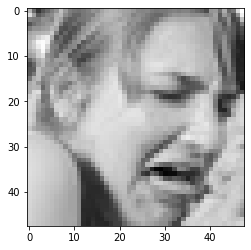

In [ ]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img,cmap='gray');

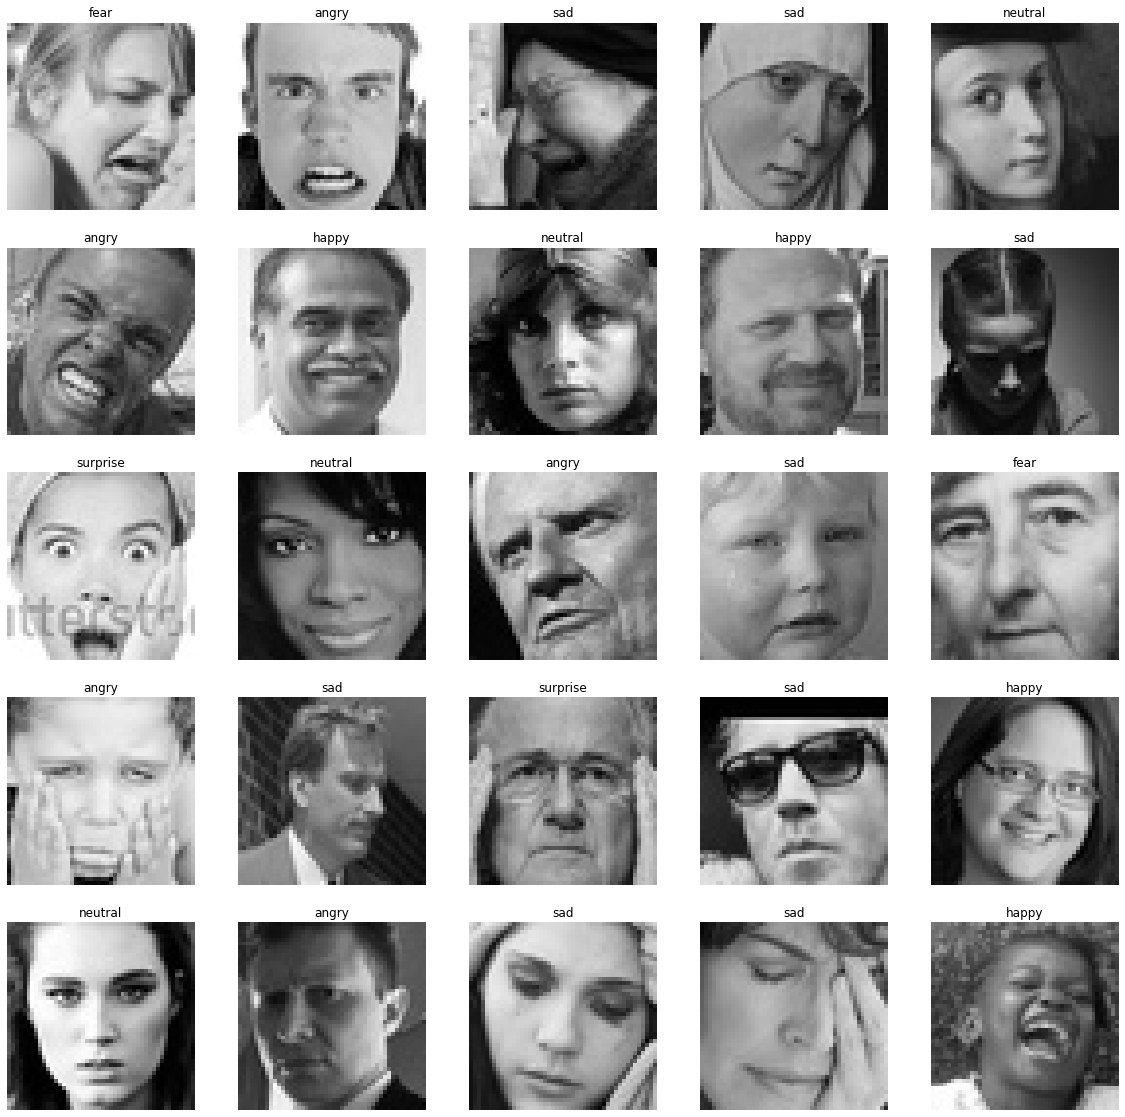

In [ ]:
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for idx, file, label in files.itertuples():
    plt.subplot(5,5,idx+1)
    image = load_img(file)
    image = np.array(image)
    plt.imshow(image,cmap='gray')
    plt.title(label)
    plt.axis('off')

Creating Training and Validation sets of data

In [ ]:
def featureExtraction(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        features.append(np.array(img))
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

In [ ]:
trainFeatures = featureExtraction(train['image'])

  0%|          | 0/28821 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


In [ ]:
testFeatures = featureExtraction(validation['image'])

  0%|          | 0/7066 [00:00<?, ?it/s]

In [ ]:
x_train = trainFeatures/255.0
x_validation = testFeatures/255.0

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_validation = le.transform(validation['label'])

In [ ]:
y_train = to_categorical(y_train, num_classes=7)
y_validation = to_categorical(y_validation, num_classes=7)

In [ ]:
y_train[0]

array([0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [ ]:
input_shape = (48, 48, 1)
output_class = 7

In [32]:
# Model 1
model = Sequential()

model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2)) # omitting 20 percent data to break linearity if any present

model.add(Conv2D(128,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))



model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

opt = Adam(learning_rate=0.0005) #reduced the learning rate and observed that the model trains faster
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_21 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 activation_21 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_21 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 24, 24, 128)      

In [53]:
#model 1

model1 = Sequential()

model1.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.2)) # omitting 20 percent data to break linearity if any present

model1.add(Conv2D(128,(3,3), padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.2))

model1.add(Conv2D(512,(3,3), padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.2))


model1.add(Flatten())

model1.add(Dense(256))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(Dropout(0.25))

model1.add(Dense(512))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(Dropout(0.25))

model1.add(Dense(7, activation='softmax'))

opt = Adam(learning_rate=0.0005)
model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_58 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 activation_58 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_58 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_37 (Conv2D)          (None, 24, 24, 128)     

In [54]:
history = model1.fit(x=x_train, y=y_train, batch_size=128, epochs=6, validation_data=(x_validation, y_validation))

Epoch 1/6
226/226 [==============================] - 16s 52ms/step - loss: 1.7423 - accuracy: 0.3393 - val_loss: 1.9056 - val_accuracy: 0.2846
Epoch 2/6
226/226 [==============================] - 11s 50ms/step - loss: 1.4390 - accuracy: 0.4484 - val_loss: 1.6639 - val_accuracy: 0.3493
Epoch 3/6
226/226 [==============================] - 11s 50ms/step - loss: 1.2987 - accuracy: 0.5022 - val_loss: 1.4202 - val_accuracy: 0.4614
Epoch 4/6
226/226 [==============================] - 11s 50ms/step - loss: 1.1993 - accuracy: 0.5445 - val_loss: 1.2052 - val_accuracy: 0.5419
Epoch 5/6
226/226 [==============================] - 11s 50ms/step - loss: 1.1198 - accuracy: 0.5686 - val_loss: 1.2191 - val_accuracy: 0.5474
Epoch 6/6
226/226 [==============================] - 11s 50ms/step - loss: 1.0588 - accuracy: 0.5985 - val_loss: 1.2028 - val_accuracy: 0.5466


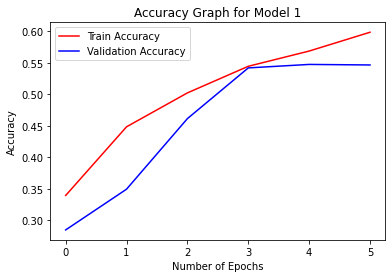

In [55]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(len(accuracy))
plt.plot(epochs,accuracy,'r',label='Train Accuracy')
plt.plot(epochs,val_accuracy,'b',label='Validation Accuracy')
plt.title('Accuracy Graph for Model 1')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend();

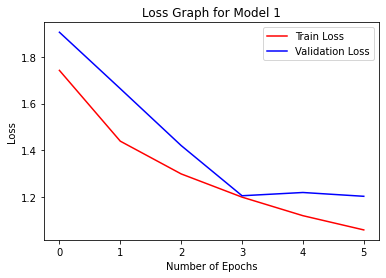

In [56]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs,loss,'r',label='Train Loss')
plt.plot(epochs,val_loss,'b',label='Validation Loss')
plt.title('Loss Graph for Model 1')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend();

In [58]:
# model 2

model2 = Sequential()

model2.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2)) # omitting 20 percent data to break linearity if any present

model2.add(Conv2D(128,(3,3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))

model2.add(Conv2D(512,(3,3), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))


model2.add(Flatten())

model2.add(Dense(256))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.25))

model2.add(Dense(512))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.25))

model2.add(Dense(7, activation='softmax'))

opt = Adam(learning_rate=0.005) #reduced the learning rate and observed that the model trains faster
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_68 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 activation_68 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_68 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_43 (Conv2D)          (None, 24, 24, 128)     

In [59]:
history = model2.fit(x=x_train, y=y_train, batch_size=128, epochs=5, validation_data=(x_validation, y_validation))

Epoch 1/5
226/226 [==============================] - 18s 56ms/step - loss: 1.7397 - accuracy: 0.3294 - val_loss: 1.9713 - val_accuracy: 0.2596
Epoch 2/5
226/226 [==============================] - 13s 57ms/step - loss: 1.3802 - accuracy: 0.4678 - val_loss: 1.5241 - val_accuracy: 0.4090
Epoch 3/5
226/226 [==============================] - 11s 50ms/step - loss: 1.2275 - accuracy: 0.5292 - val_loss: 1.2586 - val_accuracy: 0.5211
Epoch 4/5
226/226 [==============================] - 12s 53ms/step - loss: 1.1270 - accuracy: 0.5692 - val_loss: 1.2521 - val_accuracy: 0.5323
Epoch 5/5
226/226 [==============================] - 12s 53ms/step - loss: 1.0418 - accuracy: 0.6057 - val_loss: 1.2134 - val_accuracy: 0.5451


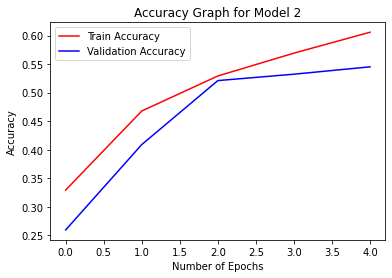

In [60]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(len(accuracy))
plt.plot(epochs,accuracy,'r',label='Train Accuracy')
plt.plot(epochs,val_accuracy,'b',label='Validation Accuracy')
plt.title('Accuracy Graph for Model 2')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend();

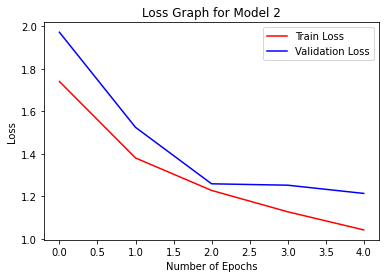

In [61]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs,loss,'r',label='Train Loss')
plt.plot(epochs,val_loss,'b',label='Validation Loss')
plt.title('Loss Graph for Model 2')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend();

In [62]:
# model 3

model3 = Sequential()

model3.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.2)) # omitting 20 percent data to break linearity if any present

model3.add(Conv2D(128,(3,3), padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.2))

model3.add(Conv2D(512,(3,3), padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.2))


model3.add(Flatten())

model3.add(Dense(256))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Dropout(0.25))

model3.add(Dense(512))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Dropout(0.25))

model3.add(Dense(7, activation='softmax'))

opt = Adam(learning_rate=0.001) #reduced the learning rate and observed that the model trains faster
model3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model3.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_73 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 activation_73 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_73 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_46 (Conv2D)          (None, 24, 24, 128)     

In [63]:
history = model3.fit(x=x_train, y=y_train, batch_size=128, epochs=7, validation_data=(x_validation, y_validation))

Epoch 1/7
226/226 [==============================] - 17s 55ms/step - loss: 1.7166 - accuracy: 0.3452 - val_loss: 1.9266 - val_accuracy: 0.3271
Epoch 2/7
226/226 [==============================] - 11s 50ms/step - loss: 1.3739 - accuracy: 0.4694 - val_loss: 1.5024 - val_accuracy: 0.3987
Epoch 3/7
226/226 [==============================] - 11s 50ms/step - loss: 1.2307 - accuracy: 0.5312 - val_loss: 1.2362 - val_accuracy: 0.5283
Epoch 4/7
226/226 [==============================] - 11s 50ms/step - loss: 1.1236 - accuracy: 0.5744 - val_loss: 1.2296 - val_accuracy: 0.5350
Epoch 5/7
226/226 [==============================] - 11s 50ms/step - loss: 1.0527 - accuracy: 0.6025 - val_loss: 1.4645 - val_accuracy: 0.4362
Epoch 6/7
226/226 [==============================] - 11s 49ms/step - loss: 0.9850 - accuracy: 0.6303 - val_loss: 1.1142 - val_accuracy: 0.5829
Epoch 7/7
226/226 [==============================] - 11s 50ms/step - loss: 0.9112 - accuracy: 0.6600 - val_loss: 1.2242 - val_accuracy: 0.5487

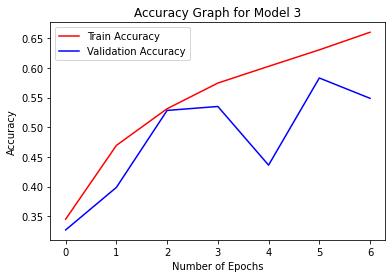

In [64]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(len(accuracy))
plt.plot(epochs,accuracy,'r',label='Train Accuracy')
plt.plot(epochs,val_accuracy,'b',label='Validation Accuracy')
plt.title('Accuracy Graph for Model 3')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend();

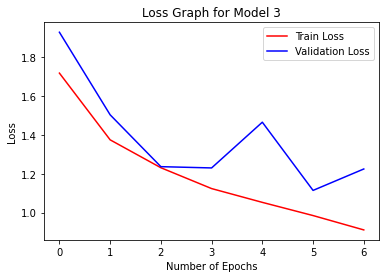

In [65]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs,loss,'r',label='Train Loss')
plt.plot(epochs,val_loss,'b',label='Validation Loss')
plt.title('Loss Graph for Model 3')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend();

In [42]:
# model 4

model4 = Sequential()

model4.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.2)) # omitting 20 percent data to break linearity if any present

model4.add(Conv2D(128,(3,3), padding='same'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.2))

model4.add(Conv2D(512,(3,3), padding='same'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.2))

model4.add(Conv2D(512,(3,3), padding='same'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.2))

model4.add(Flatten())

model4.add(Dense(256))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(Dropout(0.25))

model4.add(Dense(512))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(Dropout(0.25))

model4.add(Dense(7, activation='softmax'))

opt = Adam(learning_rate=0.0005) 
model4.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model4.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_52 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 activation_52 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_52 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_33 (Conv2D)          (None, 24, 24, 128)     

In [43]:
history = model4.fit(x=x_train, y=y_train, batch_size=128, epochs=50, validation_data=(x_validation, y_validation))

Epoch 1/50
226/226 [==============================] - 18s 64ms/step - loss: 1.8273 - accuracy: 0.2983 - val_loss: 2.0756 - val_accuracy: 0.2583
Epoch 2/50
226/226 [==============================] - 15s 66ms/step - loss: 1.5290 - accuracy: 0.4148 - val_loss: 2.1444 - val_accuracy: 0.3350
Epoch 3/50
226/226 [==============================] - 15s 65ms/step - loss: 1.3573 - accuracy: 0.4800 - val_loss: 1.2839 - val_accuracy: 0.5048
Epoch 4/50
226/226 [==============================] - 15s 65ms/step - loss: 1.2468 - accuracy: 0.5236 - val_loss: 1.4738 - val_accuracy: 0.4578
Epoch 5/50
226/226 [==============================] - 15s 64ms/step - loss: 1.1726 - accuracy: 0.5515 - val_loss: 1.1499 - val_accuracy: 0.5594
Epoch 6/50
226/226 [==============================] - 15s 64ms/step - loss: 1.1168 - accuracy: 0.5754 - val_loss: 1.1481 - val_accuracy: 0.5607
Epoch 7/50
226/226 [==============================] - 15s 65ms/step - loss: 1.0615 - accuracy: 0.5980 - val_loss: 1.1340 - val_accuracy:

View the model Architecture

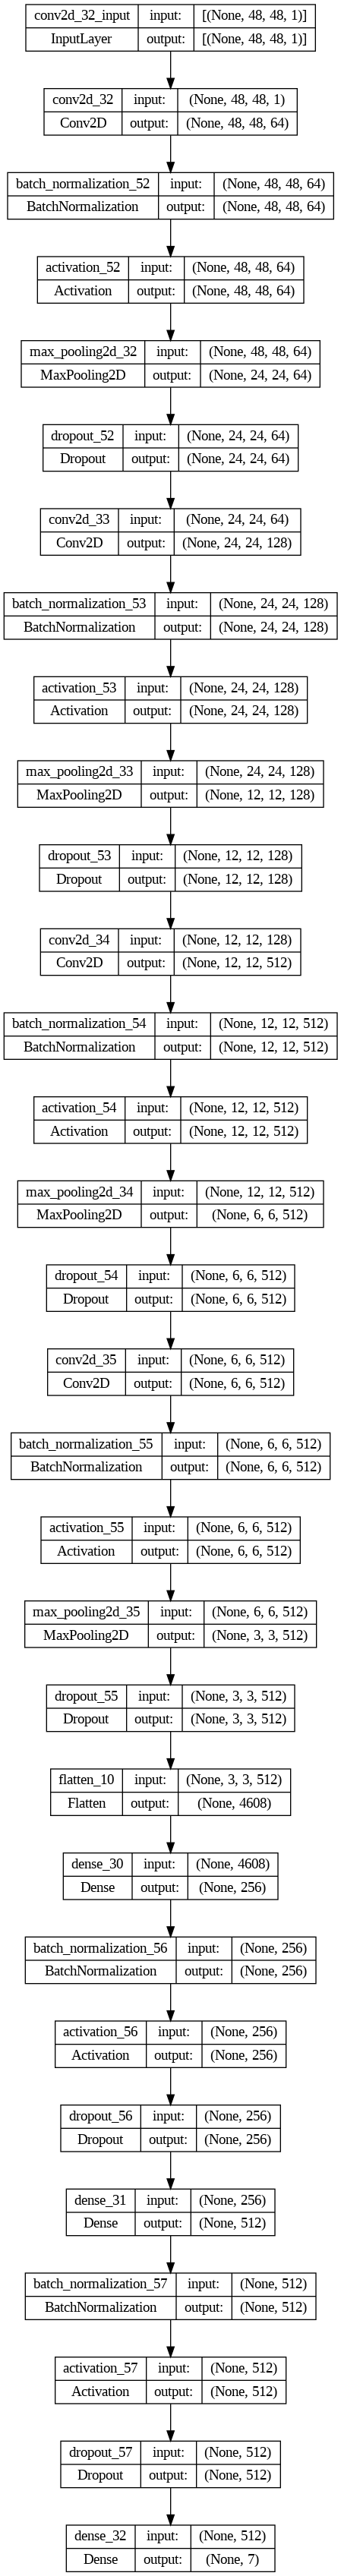

In [44]:
plot_model(model4, to_file='model.png', show_shapes=True, show_layer_names=True)
Image('model.png',width=400, height=2000)

In [ ]:
from PIL import Image

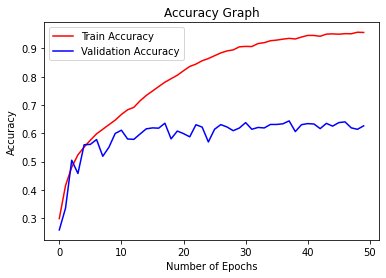

In [51]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(len(accuracy))
plt.plot(epochs,accuracy,'r',label='Train Accuracy')
plt.plot(epochs,val_accuracy,'b',label='Validation Accuracy')
plt.title('Accuracy Graph for Model 4')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend();


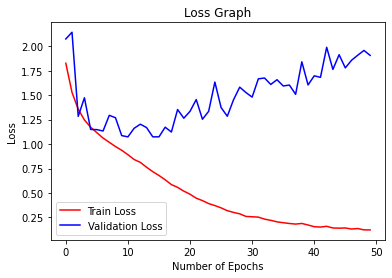

In [52]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs,loss,'r',label='Train Loss')
plt.plot(epochs,val_loss,'b',label='Validation Loss')
plt.title('Loss Graph for Model 4')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend();

In [66]:
import tensorflow as tf
model.save('assignment1_facial_emotion.h5')
model = tf.keras.models.load_model('assignment1_facial_emotion.h5')

Original Emotion: sad
1/1 [==============================] - 0s 227ms/step
Predicted Emotion: disgust


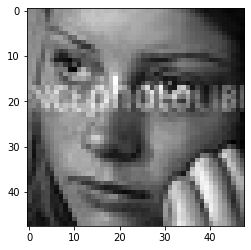

In [67]:
import random
indexOfImage = random.randint(0, len(validation))
print("Original Emotion:", validation['label'][indexOfImage])
predictValue = model.predict(x_validation[indexOfImage].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([predictValue.argmax()])[0]
print("Predicted Emotion:", prediction_label)
plt.imshow(x_validation[indexOfImage].reshape(48, 48), cmap='gray');

Original Emotion: neutral
1/1 [==============================] - 0s 21ms/step
Predicted Emotion: disgust


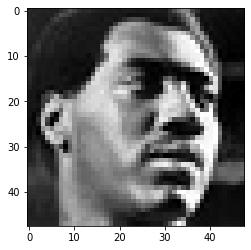

In [68]:
indexOfImage = random.randint(0, len(validation))
print("Original Emotion:", validation['label'][indexOfImage])
predictValue = model.predict(x_validation[indexOfImage].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([predictValue.argmax()])[0]
print("Predicted Emotion:", prediction_label)
plt.imshow(x_validation[indexOfImage].reshape(48, 48), cmap='gray');

Original Emotion: happy
1/1 [==============================] - 0s 19ms/step
Predicted Emotion: disgust


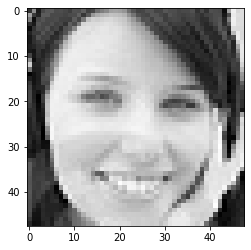

In [69]:
indexOfImage = random.randint(0, len(validation))
print("Original Emotion:", validation['label'][indexOfImage])
predictValue = model.predict(x_validation[indexOfImage].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([predictValue.argmax()])[0]
print("Predicted Emotion:", prediction_label)
plt.imshow(x_validation[indexOfImage].reshape(48, 48), cmap='gray');

Original Emotion: surprise
1/1 [==============================] - 0s 19ms/step
Predicted Emotion: disgust


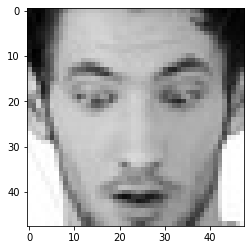

In [70]:
indexOfImage = random.randint(0, len(validation))
print("Original Emotion:", validation['label'][indexOfImage])
predictValue = model.predict(x_validation[indexOfImage].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([predictValue.argmax()])[0]
print("Predicted Emotion:", prediction_label)
plt.imshow(x_validation[indexOfImage].reshape(48, 48), cmap='gray');

Original Emotion: happy
1/1 [==============================] - 0s 18ms/step
Predicted Emotion: happy


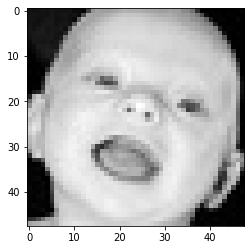

In [71]:
indexOfImage = random.randint(0, len(validation))
print("Original Emotion:", validation['label'][indexOfImage])
predictValue = model.predict(x_validation[indexOfImage].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([predictValue.argmax()])[0]
print("Predicted Emotion:", prediction_label)
plt.imshow(x_validation[indexOfImage].reshape(48, 48), cmap='gray');


Original Emotion: happy
1/1 [==============================] - 0s 19ms/step
Predicted Emotion: disgust


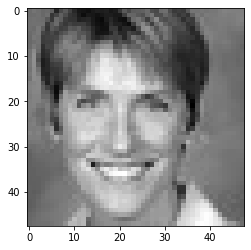

In [72]:
indexOfImage = random.randint(0, len(validation))
print("Original Emotion:", validation['label'][indexOfImage])
predictValue = model.predict(x_validation[indexOfImage].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([predictValue.argmax()])[0]
print("Predicted Emotion:", prediction_label)
plt.imshow(x_validation[indexOfImage].reshape(48, 48), cmap='gray');

Original Emotion: sad
1/1 [==============================] - 0s 20ms/step
Predicted Emotion: happy


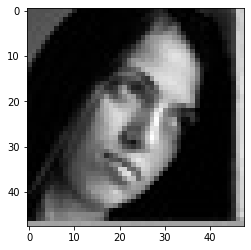

In [73]:
indexOfImage = random.randint(0, len(validation))
print("Original Emotion:", validation['label'][indexOfImage])
predictValue = model.predict(x_validation[indexOfImage].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([predictValue.argmax()])[0]
print("Predicted Emotion:", prediction_label)
plt.imshow(x_validation[indexOfImage].reshape(48, 48), cmap='gray');